In [202]:
from rdkit import Chem
import pandas as pd
import numpy as np
from tqdm import tqdm

R = 0.0083145  # kJ/(mol*K)
T = 298  # K

solvent_dict = {
#     'Acetat': ('CC(=O)[O-]', 'Acetate'),
    'Acetic-acid': ('CC(=O)O', 'Acetic acid', 6.15, 'small acid'),
    'Aceton': ('CC(=O)C', 'Acetone', 20.7, 'polar aprotic'),
    'Acetonitrile': ('CC#N', 'Acetonitrile', 37.5, 'polar aprotic'),
    'Ammonia': ('N', 'Ammonia', 16.61, 'polar aprotic'),
    'Ammonium': ('[NH4+]', 'Ammonium', 7.1, 'water'), #ammonium chloride - solid phase. Will adjust with solution conc. 
    'Benzene': ('c1ccccc1', 'Benzene', 2.28, 'nonpolar'),
#     'Benzoat': ('[O-]C(=O)c1ccccc1', 'Benzoate'),
    'Benzylacetat': ('CC(=O)OCc1ccccc1', 'Benzyl acetate', 5.34, 'polar aprotic'),
    'Butanon': ('CCC(=O)C', 'Butanone', 18.85, 'polar aprotic'),
#     'Chloride': ('[Cl-]', 'Chloride', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc.
    'Chloroform': ('C(Cl)(Cl)Cl', 'Chloroform', 4.8, 'nonpolar'),
    'Cyclohexan': ('C1CCCCC1', 'Cyclohexane', 2.02, 'nonpolar'),
    'Di-2-butylamin': ('CC[C@H](C)N[C@H](C)CC', 'Di-2-butylamine', 4.71, 'nonpolar'),
    'Dichlormethan': ('C(Cl)Cl', 'Dichloromethane', 8.93, 'polar aprotic'),
    'Diethanolamin': ('OCCNCCO', 'Diethanolamine', 25.75, 'polar protic'),
#     'Diethanolammonium': ('OCC[NH2+]CCO', 'Diethanolammonium'),
#     'Diethylenamin': ('CCNCC', 'Diethylamine', 3.8, 'nonpolar'), #Average of three sources - 3.6, 3.8, 3.92 all reported.
#     'Diethylenammonium': ('CC[NH2+]CC', 'Diethylenammonium'),
    'Diethylether': ('CCOCC', 'Diethylether',4.33, 'nonpolar'),
    'Dioctylether': ('CCCCCCCCOCCCCCCC', 'Dioctylether', 2, 'nonpolar'), #Estimate
    'DMA': ('CC(=O)N(C)C', 'DMA', 37.8, 'polar aprotic'),
    'DMF': ('CN(C)C=O', 'DMF', 36.7, 'polar aprotic'),
    'DMSO': ('CS(=O)C', 'DMSO', 46.7, 'polar aprotic'),
    'EC': ('C1COC(=O)O1', 'EC', 89.78, 'polar aprotic'),
    'EMC': ('CCOC(=O)OC', 'EMC', 2.99, 'nonpolar'),
    'Ethanol': ('CCO', 'Ethanol', 24.55, 'polar protic'),
    'Ethylacetat': ('CCOC(=O)C', 'Ethyl acetate', 6.02, 'polar aprotic'),
#     'Ethylenamin': ('C=CN', 'Ethylenamine', 6.94, 'polar protic'),
#     'Ethylenammonium': ('CC[NH3+]', 'Ethylenammonium'),
    'Ethylenglykol': ('OCCO', 'Ethylene glycol', 37.0, 'polar protic'),
#     'Formiat': ('C(=O)[O-]', 'Formate'),
    'Formic-acid': ('O=CO', 'Formic acid', 51.1, 'small acid'),
    'g-Butyrolacton': ('O=C1CCCO1', 'γ-Butyrolactone', 41.68, 'polar aprotic'),
    'Glycerin': ('OCC(O)CO', 'Glycerol', 46.5, 'polar protic'),
    'H2O': ('O', 'Water', 80.1, 'water'),
    'H2SO4': ('O=S(=O)(O)O', 'Sulfuric acid', 100, 'small acid'), #Lots of varying reports 21.9, 100, 84, 80, 106. Chosen 100 for now.
    'Hexafluorbenzol': ('Fc1c(F)c(F)c(F)c(F)c1F', 'Hexafluorobenzene',  2.05, 'nonpolar'),
    'Isooctane': ('CC(C)CC(C)(C)C', 'Isooctane', 1.94, 'nonpolar'),
    'Isopropanol': ('CC(O)C', 'Isopropanol', 17.9, 'polar protic'),
#     'Methanolat': ('C[O-]', 'Methanolate'),
    'n-Hexan': ('CCCCCC', 'n-Hexane', 1.88, 'nonpolar'),
    'Nonandecanol': ('CCCCCCCCCCCCCCCCCCCO', 'Nonandecanol', 3.82, 'fatty alcohol'),
    'Octanol': ('CCCCCCCCO', 'Octanol', 10.3, 'fatty alcohol'),
    'o-Dichlorbenzol': ('Clc1ccccc1Cl', 'o-Dichlorobenzene', 9.93, 'nonpolar'),
#     'Oleic-methyl-ester': ('CCCCCCCCC=CCCCCCCCC(=O)OC', 'Oleic methyl ester', 3.21, 'nonpolar'),
    'Perfluoro-hexan': ('C(C(C(C(F)(F)F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F', 'Perfluorohexane', 1.57, 'nonpolar'),
    'Propylenglykol': ('C[C@@H](O)CO', 'Propylene glycol', 32.0, 'polar protic'),
#     'Tetraethylenammonium': ('CC[N+](CC)(CC)CC', 'Tetraethylenammonium'),
    'THF': ('O1CCCC1', 'THF', 7.58, 'polar aprotic'),
    'Toluol': ('Cc1ccccc1', 'Toluene', 2.38, 'nonpolar'),
    'Tributylphosphat': ('O=P(OCCCC)(OCCCC)OCCCC', 'Tributyl phosphate', 8.29, 'polar aprotic'),
    'Triethanolamin': ('OCCN(CCO)CCO', 'Triethanolamine', 28.11, 'polar protic'),
#     'Triethanolammonium': ('OCC[NH+](CCO)CCO', 'Triethanolammonium'),
#     'Triethylenamin': ('CCN(CC)CC', 'Triethylamine', 2.42, 'nonpolar'),
#     'Triethylenammonium': ('CC[NH+](CC)CC', 'Triethylammonium'),
    'Triglyme': ('COCCOCCOCCOC', 'Triglyme', 7.50, 'polar aprotic'),
    'Urea': ('NC(N)=O', 'Urea', 2.9, 'urea'),
}

# https://www.engineeringtoolbox.com/liquid-dielectric-constants-d_1263.html
# https://people.chem.umass.edu/xray/solvent.html
# https://depts.washington.edu/eooptic/linkfiles/dielectric_chart%5B1%5D.pdf

solvent_keys = list(solvent_dict.keys())
solvent_smiles = list(zip(*solvent_dict.values()))[0]
solvent_names = list(zip(*solvent_dict.values()))[1]
dielctric_constants = list(zip(*solvent_dict.values()))[2]
solvent_classes = list(zip(*solvent_dict.values()))[3]
solvent_class_dict = {s:c for s,c in zip(solvent_names, solvent_classes)}
# smiles_to_names_dict = {k:v for k,v in zip(solvents, solvent_names)}
# solvent_class_dict = {v[1]:v[3] for k,v in solvent_dict.items()}
# solvent_class_order = ['nonpolar', 'fatty alcohol', 'polar aprotic', 'polar protic', 'small acid', 'urea', 'water']

In [203]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


def lower_triangular_heatmap(data, col_labels, row_labels, hide_diags=False, annot_fmt=".0f",
                             cbar_title="% Agreement"):
    
#     if hide_diags:
#         col_labels = col_labels[:-1]
#         row_labels = row_labels[1:]

    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = hide_diags

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(24, 24))

    # Generate a custom diverging colormap
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(data, mask=mask, cmap=cmap, annot=True,  fmt=annot_fmt,
                           yticklabels=row_labels, xticklabels=col_labels, annot_kws=dict(size=12),
                           square=True, linewidths=.5, cbar_kws=dict(shrink=.6, pad=-0.1))

    # rotate bottom tick labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-40,ha="left",rotation_mode='anchor')
    
    # colorbar font/tick sizes and label
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    cbar.ax.set_title(cbar_title, fontsize=16, pad=30)
    
    # tick sizes
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)

In [47]:
coords_df = pd.read_pickle("../data/debug/dft_coords.pkl.gz")

In [204]:
data_df = pd.read_pickle("../data/debug/free_energy.pkl.gz")
data_df = data_df[data_df['solvent'].isin(solvent_keys)]
data_df['G(gas+solvation)'] = data_df['E(gas)'] + data_df['G(solvation)']
data_df['G(gas+RRHO)'] = data_df['E(gas)'] + data_df['G(RRHO)']

pd.set_option('display.max_rows', 20)
data_df

,mol_id,conf_id,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),G(solvation),G(RRHO),G(gas+solvation),G(gas+RRHO)
5,molecule_16112,conf00008,Acetic-acid,0.000,0.000,0.000,-2502242.880,-2501872.877,-2501894.832,-21.954,370.002,-2502264.834,-2501872.878
6,molecule_16112,conf00002,Acetic-acid,0.136,0.138,0.110,-2502242.744,-2501872.739,-2501894.722,-21.983,370.005,-2502264.727,-2501872.739
7,molecule_16112,conf00007,Acetic-acid,0.095,0.116,1.350,-2502242.785,-2501872.762,-2501893.482,-20.720,370.023,-2502263.505,-2501872.762
8,molecule_16112,conf00009,Acetic-acid,0.222,2.063,2.006,-2502242.658,-2501870.814,-2501892.826,-22.011,371.844,-2502264.669,-2501870.814
9,molecule_16112,conf00006,Acetic-acid,2.659,2.446,2.089,-2502240.221,-2501870.431,-2501892.743,-22.311,369.789,-2502262.532,-2501870.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,molecule_112040377,conf00014,Urea,13.579,13.459,7.800,-3234419.896,-3234174.154,-3234215.044,-40.891,245.742,-3234460.787,-3234174.154
724,molecule_112040377,conf00009,Urea,8.712,8.589,8.618,-3234424.763,-3234179.023,-3234214.226,-35.203,245.740,-3234459.966,-3234179.023
725,molecule_112040377,conf00003,Urea,13.482,13.446,8.902,-3234419.993,-3234174.166,-3234213.943,-39.777,245.827,-3234459.770,-3234174.166
726,molecule_112040377,conf00018,Urea,17.171,16.121,9.541,-3234416.304,-3234171.491,-3234213.303,-41.812,244.813,-3234458.116,-3234171.491


In [15]:
avail_mol_ids = data_df.mol_id.unique()

In [16]:
pd.set_option('display.max_rows', None)
id_to_smi = pd.read_csv("../data/full/id_smiles_all.smi").set_index("ID")
id_to_smi[id_to_smi.index.isin(data_df.mol_id.unique())]

,SMILES
ID,
molecule_135591618,O=C(N1CCOCC1)N1CCCN(CC1)S(=O)(=O)C1CC1
molecule_43786693,CC(Oc1ccccc1NC(=O)N1CCC(CC1)c1onc(n1)c1ccccn1)C
epa_DTXCID50502367,C[Si](C)(C)OC12CCC1(O[Si](C)(C)C)C(F)(F)C2=O
molecule_43985498,COc1cc(OC)c(cc1NC(=O)C1(C)CCN(CC1)C(=O)OC(C)(C...
epa_DTXCID5026093,O=c1[nH]c2cc(C(F)(F)F)c(N3CCOCC3)cc2n(CP(=O)(O...
molecule_1131244,S=C1S/C(=C/c2ccc(o2)c2ccccc2[N+](=O)[O-])/C(=O...
molecule_115098703,CCN(C(=O)c1ccc(cc1OC)Br)CC1CCCNC1
molecule_296994727,CCn1ccnc1[C@@H]1OCC[C@H]1NC(=O)N[C@@H](c1cnccc...
molecule_297510950,Cc1cc(=O)[nH]c(n1)N1CCN(CC1)c1nc(C)nc2c1cnn2C


In [17]:
mol_id = avail_mol_ids[12]
print(mol_id)
id_to_smi.loc[mol_id].SMILES

molecule_109465604


'C[C@H]1CN(C[C@@H]1C)C(=O)Nc1ccc(nc1)C(=O)O'

In [18]:
for mol_id in avail_mol_ids:
    smi = id_to_smi.loc[mol_id].values[0]
    print(mol_id)
    print(smi)
    display(Chem.MolFromSmiles(smi))

molecule_16112
F[Si](F)(c1ccccc1)c1ccccc1


NameError: name 'Chem' is not defined

### do lowest energy conformers change between solvents?

In [206]:
solvents = data_df.solvent.unique()
n_solvents = len(solvents)
agreement, agreement_counter = np.zeros([len(solvents), len(solvents)]), 0
gas_agreement = []

dG_solution_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solv_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_rrho_pr = np.zeros([len(solvents), len(solvents)])
spearman_r_counter = 0
threshold = 20

conf_g_correction = []
n_confs_min_for_q = []
n_confs_total = []
smiles = []

partition_factor = 0.95

# add column for gas phase
for mol_id, df in tqdm(data_df.groupby("mol_id")):
    
    # skip if less than two conformers
    if len(df) <= (2*len(solvents)):
        continue
    
    # lowest energy conformer
    min_conf_soln = df.set_index('conf_id').groupby("solvent")['dG(solution)'].idxmin()
    agree = np.array(min_conf_soln.values == min_conf_soln.values[:, None], dtype=int)
    agreement += agree
    agreement_counter += 1
    
    # does conformer order change after g_solvation and rrho?
    min_conf_gas = df.set_index('conf_id').groupby("solvent")['dE(gas)'].idxmin()
    gas_agree = np.array(min_conf_soln.values == min_conf_gas.values, dtype=int)
    gas_agreement.append(gas_agree)
    
    # pearson correlation
    low_energy_confs = df[df['dG(solution)']<threshold].conf_id.unique()
    df_low_energy_confs = df[df['conf_id'].isin(low_energy_confs)]
    
    # skip if less than two conformers
    # mutiple columns for "values" will return cross correlations
    if len(df_low_energy_confs) > (2*len(solvents)):
        pr = df_low_energy_confs.pivot(index='conf_id', columns='solvent', \
                                       values=['dE(gas)', 'dG(solution)', 'G(gas+solvation)', 'G(gas+RRHO)']).corr(method='spearman').values
        dG_solution_dG_solution_pr += pr[1*n_solvents:(1*n_solvents+n_solvents), 1*n_solvents:(1*n_solvents+n_solvents)]
        dE_gas_dG_solution_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 1*n_solvents:(1*n_solvents+n_solvents)]
        dE_gas_dG_solv_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 2*n_solvents:(2*n_solvents+n_solvents)]
        dE_gas_dG_rrho_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 3*n_solvents:(3*n_solvents+n_solvents)]
        spearman_r_counter += 1
        
        # partition functions
        q_df = df.sort_values(['solvent', 'dG(solution)'])
        q_df['boltzmann_factor_pre'] = np.exp(-q_df['dG(solution)'] / (R*T))
        q_df['boltzmann_factor'] = q_df.groupby('solvent')['boltzmann_factor_pre'].apply(lambda x: \
                                            x / np.sum(x))
        q_df['boltzmann_factor_cum'] = q_df.groupby('solvent')['boltzmann_factor_pre'].apply(lambda x: \
                                            np.cumsum(x) / np.cumsum(x).max())
        n_confs_min = q_df.groupby('solvent')['boltzmann_factor_cum'].apply(lambda x: \
                                            (x < partition_factor).argmin()+1).values
        n_confs_total.append(q_df.groupby('solvent')['mol_id'].count().values)
        n_confs_min_for_q.append(n_confs_min)
        
        # how much do conformers influence G(solution)
        q_df_solv = q_df.groupby("solvent")
        correction = q_df_solv.apply(lambda x: np.sum(x['dG(solution)'] * x['boltzmann_factor'])).sort_index()
        conf_g_correction.append(correction.values)
        
        # save smiles
        smiles.append(id_to_smi[id_to_smi.index==mol_id].SMILES.values[0])
    
agreement = agreement/agreement_counter * 100
# gas_agreement = gas_agreement/agreement_counter * 100

dG_solution_dG_solution_pr = dG_solution_dG_solution_pr/spearman_r_counter
dE_gas_dG_solution_pr = dE_gas_dG_solution_pr/spearman_r_counter
dE_gas_dG_solv_pr = dE_gas_dG_solv_pr/spearman_r_counter
dE_gas_dG_rrho_pr = dE_gas_dG_rrho_pr/spearman_r_counter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2599/2599 [01:57<00:00, 22.04it/s]


In [169]:
q_df

,mol_id,conf_id,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),G(solvation),G(RRHO),G(gas+solvation),G(gas+RRHO),boltzmann_factor_pre,boltzmann_factor,boltzmann_factor_cum
7,pka_extern_7111,conf00001,Acetic-acid,4.374,0.000,0.000,-2342606.161,-2341806.388,-2341833.898,-27.509,799.773,-2342633.670,-2341806.388,1.000000,0.516243,0.516243
8,pka_extern_7111,conf00002,Acetic-acid,4.405,0.014,0.184,-2342606.130,-2341806.374,-2341833.714,-27.340,799.756,-2342633.470,-2341806.374,0.928429,0.479294,0.995537
9,pka_extern_7111,conf00003,Acetic-acid,0.000,0.819,11.932,-2342610.535,-2341805.569,-2341821.966,-16.396,804.966,-2342626.931,-2341805.569,0.008101,0.004182,0.999719
10,pka_extern_7111,conf00005,Acetic-acid,28.453,23.428,20.385,-2342582.082,-2341782.961,-2341813.512,-30.551,799.121,-2342612.633,-2341782.961,0.000267,0.000138,0.999857
11,pka_extern_7111,conf00007,Acetic-acid,27.677,23.186,20.474,-2342582.858,-2341783.202,-2341813.424,-30.222,799.655,-2342613.080,-2341783.203,0.000258,0.000133,0.999991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,pka_extern_7111,conf00003,o-Dichlorbenzol,0.000,0.819,5.593,-2342610.535,-2341805.569,-2341829.294,-23.725,804.966,-2342634.260,-2341805.569,0.104631,0.050257,0.999799
290,pka_extern_7111,conf00007,o-Dichlorbenzol,27.677,23.186,21.133,-2342582.858,-2341783.202,-2341813.753,-30.551,799.655,-2342613.409,-2341783.203,0.000198,0.000095,0.999893
291,pka_extern_7111,conf00005,o-Dichlorbenzol,28.453,23.428,21.313,-2342582.082,-2341782.961,-2341813.574,-30.613,799.121,-2342612.695,-2341782.961,0.000184,0.000088,0.999982
292,pka_extern_7111,conf00009,o-Dichlorbenzol,20.919,23.062,26.226,-2342589.616,-2341783.326,-2341808.660,-25.334,806.290,-2342614.950,-2341783.326,0.000025,0.000012,0.999994


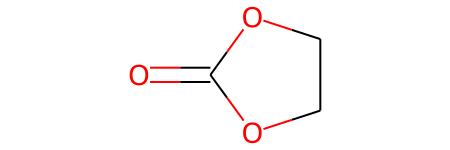

In [155]:
Chem.MolFromSmiles('C1COC(=O)O1')

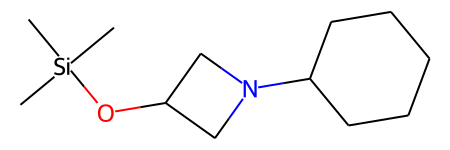

In [78]:
Chem.MolFromSmiles(id_to_smi[id_to_smi.index==mol_id].SMILES.values[0])

(array([521., 838., 470., 185.,  71.,  24.,   9.,   6.,   4.,   1.]),
 array([0.02244619, 0.61285565, 1.20326511, 1.79367458, 2.38408404,
        2.9744935 , 3.56490296, 4.15531242, 4.74572188, 5.33613134,
        5.9265408 ]),
 <BarContainer object of 10 artists>)

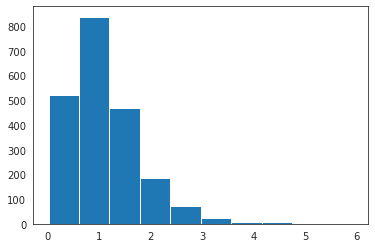

In [165]:
diff = []
for i in range(len(conf_g_correction)):
    diff.append(np.max(conf_g_correction[i]) - np.min(conf_g_correction[i]))

plt.hist(diff)

(array([384., 833., 528., 234.,  95.,  31.,  12.,   7.,   4.,   1.]),
 array([0.03593352, 0.62499425, 1.21405497, 1.8031157 , 2.39217643,
        2.98123716, 3.57029789, 4.15935862, 4.74841935, 5.33748007,
        5.9265408 ]),
 <BarContainer object of 10 artists>)

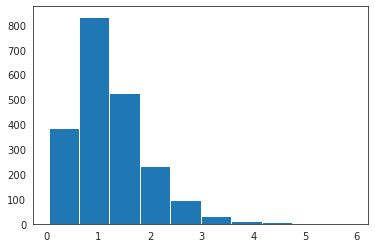

In [209]:
diff = []
for i in range(len(conf_g_correction)):
    diff.append(np.max(conf_g_correction[i]) - np.min(conf_g_correction[i]))

plt.hist(diff)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


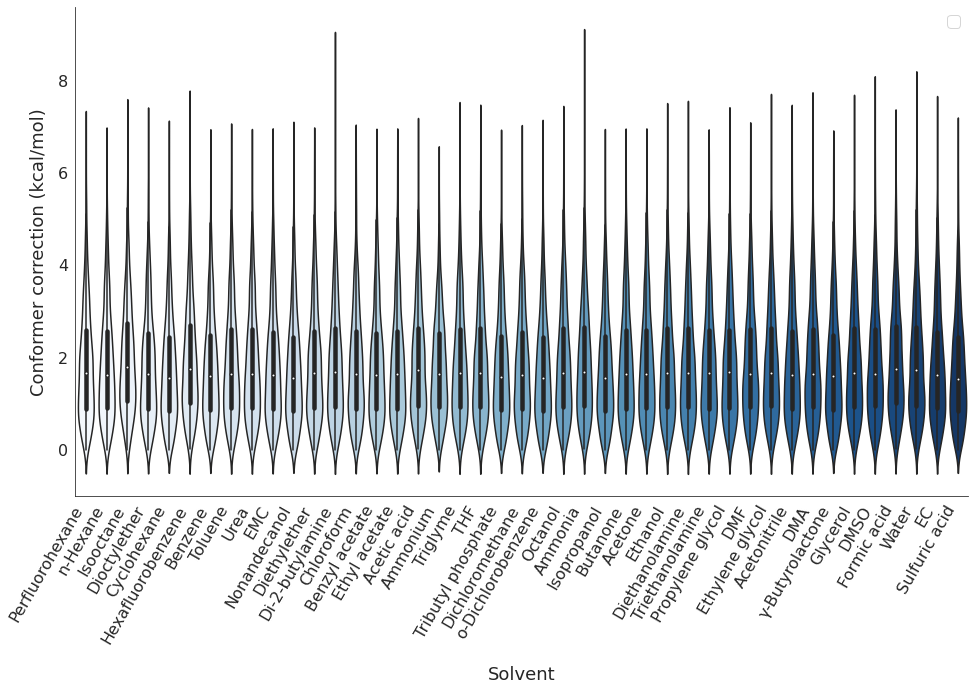

In [207]:
g_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(conf_g_correction),
    'n_confs': np.stack(n_confs_total).ravel(),
    'conf_g_correction': np.stack(conf_g_correction).ravel(),
})

ordered_solvents = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]
g_data_df['solvent_class'] = g_data_df['solvent'].apply(lambda x: solvent_class_dict[x])

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=g_data_df,
    x="solvent",
    y="conf_g_correction",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Conformer correction (kcal/mol)", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

<AxesSubplot:xlabel='n_confs', ylabel='conf_g_correction'>

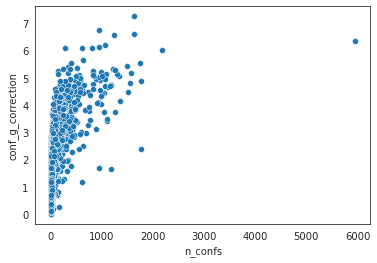

In [118]:
sns.scatterplot(
    data=g_data_df[g_data_df["solvent"]=="H2O"],
    x="n_confs",
    y="conf_g_correction",
    palette="Blues",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


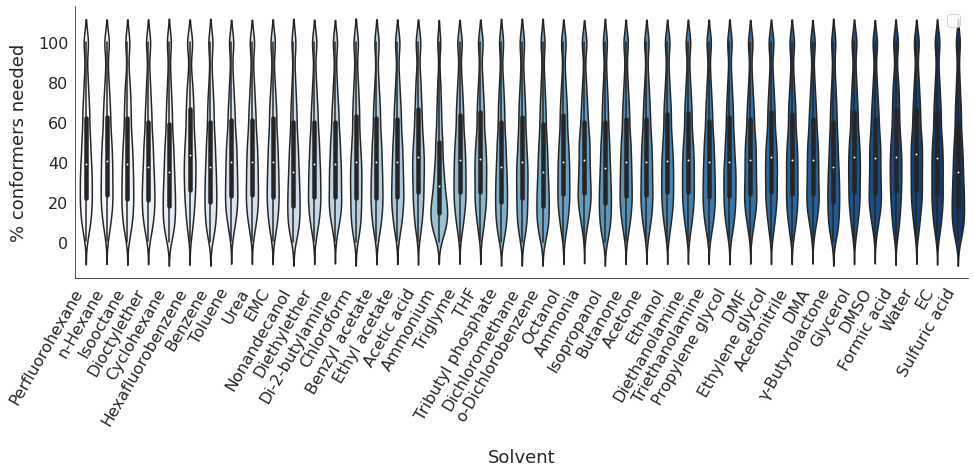

In [208]:
q_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(n_confs_total),
    'n_confs': np.stack(n_confs_total).ravel(),
    'n_confs_min': np.stack(n_confs_min_for_q).ravel(),
})

q_data_df['percent_confs_needed'] = q_data_df['n_confs_min'] / q_data_df['n_confs'] * 100
q_data_df['solvent_class'] = g_data_df['solvent'].apply(lambda x: solvent_class_dict[x])


fig, ax1 = plt.subplots(figsize=(16, 5))
sns.set_style("white")

sns.violinplot(
    data=q_data_df,
    x="solvent",
    y="percent_confs_needed",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [196]:
pd.set_option('display.max_rows', 42)
q_data_df.groupby("solvent")["percent_confs_needed"].describe()

,count,mean,std,min,25%,50%,75%,max
solvent,,,,,,,,
Acetic acid,2129.0,46.559832,26.442968,0.420168,25.000000,42.857143,66.666667,100.0
Acetone,2129.0,44.631520,26.206702,0.621118,23.529412,40.145985,61.875000,100.0
Acetonitrile,2129.0,45.339072,26.443791,0.621118,24.038462,41.463415,64.285714,100.0
Ammonia,2129.0,45.024903,25.595787,0.734049,24.598930,41.025641,60.000000,100.0
Benzene,2129.0,42.305396,27.169377,0.203666,20.129870,37.500000,60.000000,100.0
Benzyl acetate,2129.0,43.807429,26.677776,0.621118,22.222222,40.000000,62.000000,100.0
Butanone,2129.0,44.354498,26.307081,0.621118,23.076923,40.000000,61.538462,100.0
Chloroform,2129.0,43.926709,27.426833,0.248139,22.222222,40.000000,63.366337,100.0
Cyclohexane,2129.0,40.529483,27.229594,0.203666,18.181818,35.000000,59.420290,100.0


  2%|███▎                                                                                                                                                                           | 1/52 [00:04<03:38,  4.29s/it]


KeyboardInterrupt: 

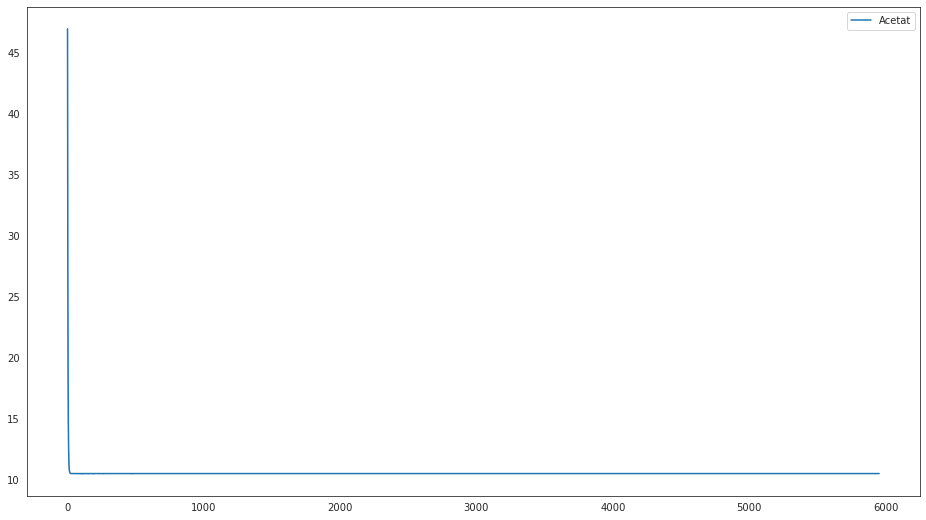

In [31]:
from scipy.optimize import curve_fit

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

xs, ys = [], []
for s in tqdm(solvents):
    
    # log norm the x data
    x = np.log(q_data_df[q_data_df['solvent']==s]["n_confs"].values)
    
    # fit params to exponential fit
    popt, pcov = curve_fit(func, x, q_data_df[q_data_df['solvent']==s]["percent_confs_needed"].values, 
                           p0=(1, 1e-6, 1))
    
    # apply params to fit and get y
    y = func(q_data_df[q_data_df['solvent']==s]["n_confs"].values, *popt)
    
    # plot unnormalized version on log scale
    sns.lineplot(
        x=np.exp(x),
        y=y,
        label=s,
        ax=ax1,
    )
    
ax1.set_xlabel("N conformers", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=10)
    
plt.xscale('log')
plt.show()

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


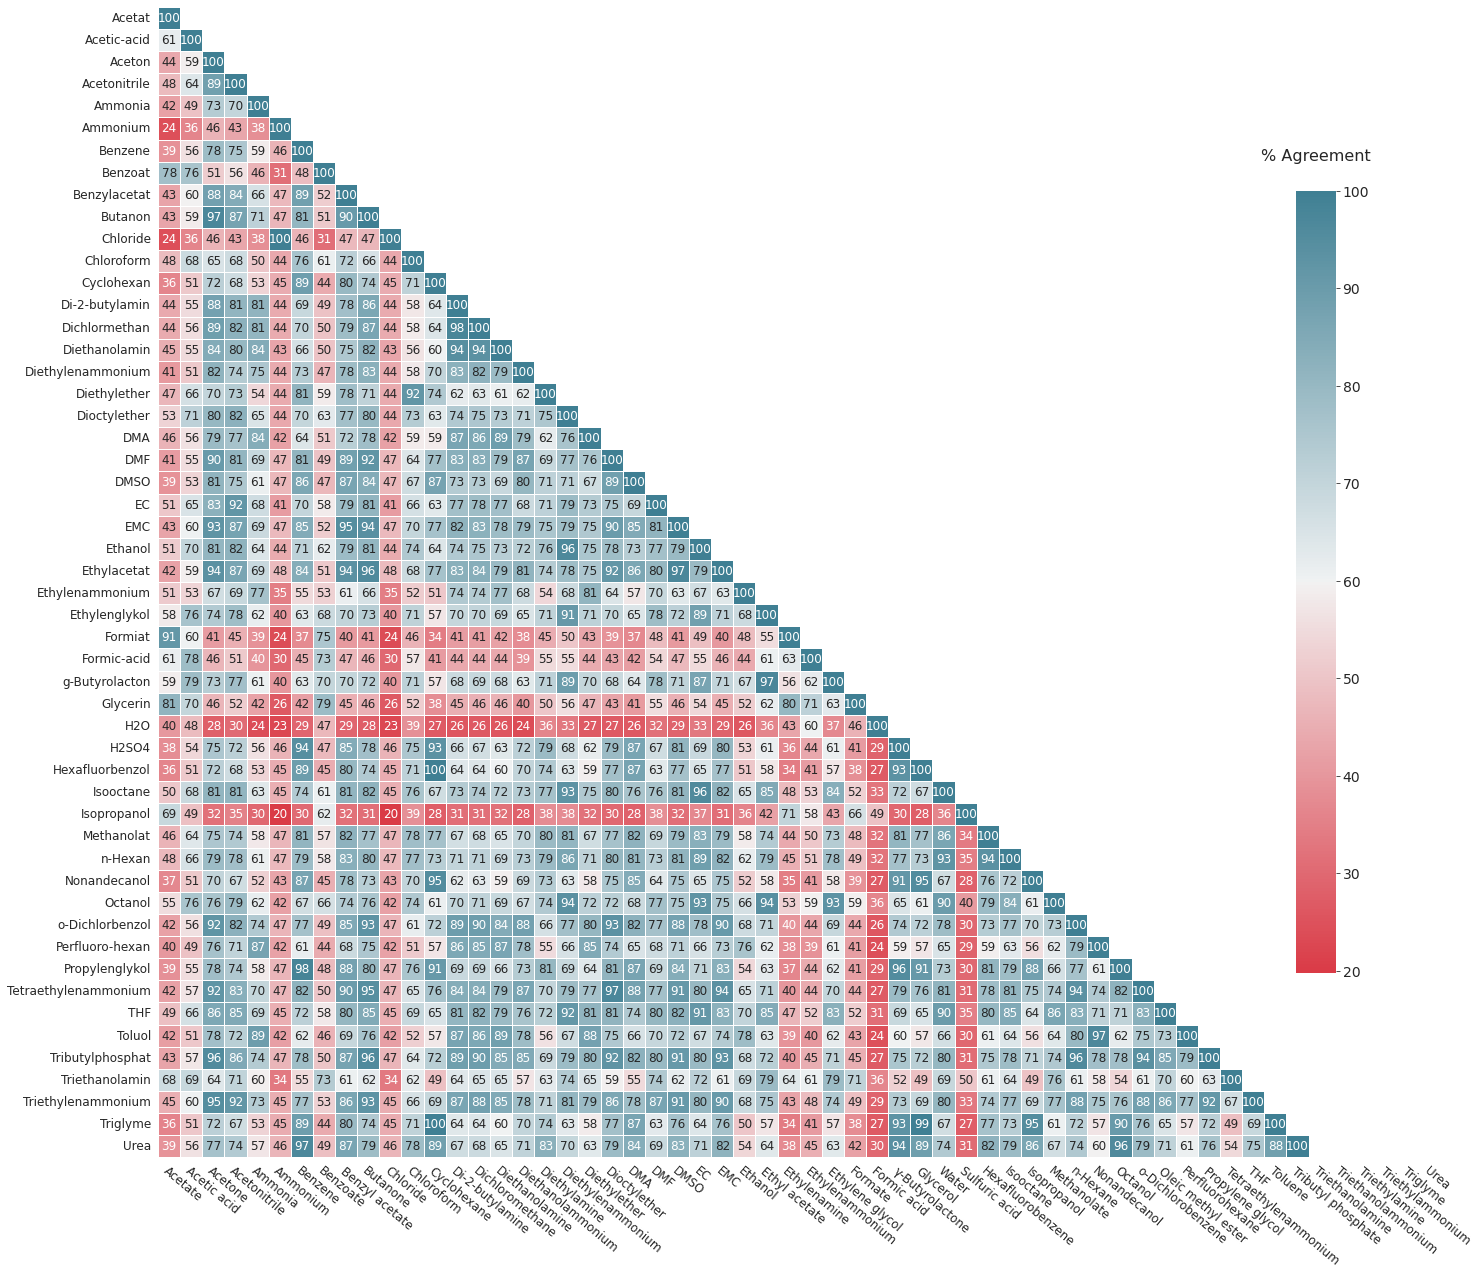

In [33]:
lower_triangular_heatmap(agreement, solvent_names, solvents)

In [ ]:
len(solvent_names)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


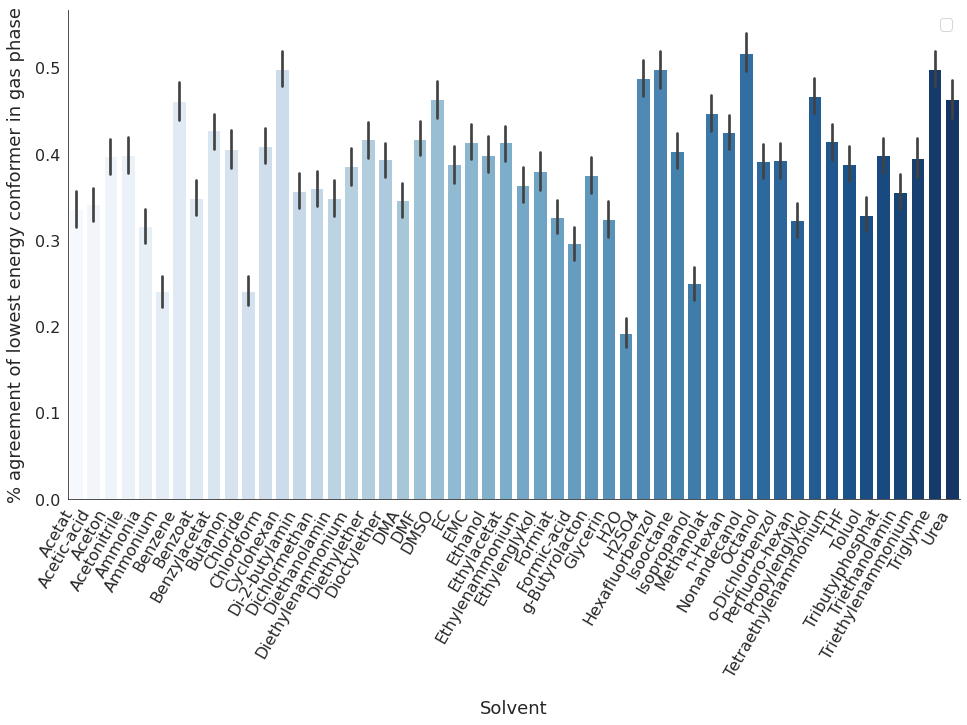

In [32]:
gas_agreement_df = pd.DataFrame({
    'solvent': solvents.tolist()*len(gas_agreement),
    'gas_agreement': np.stack(gas_agreement).ravel(),
})


fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=gas_agreement_df,
    x='solvent',
    y='gas_agreement',
    ax=ax1,
    palette="Blues",
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% agreement of lowest energy conformer in gas phase", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
lower_triangular_heatmap(dG_solution_dG_solution_pr, solvents, solvents, annot_fmt=".2f", cbar_title="Spearman")

In [ ]:
dE_gas_dG_solution_pr[0]

In [ ]:
dE_gas_dG_solv_pr[0]

In [ ]:
dE_gas_dG_rrho_pr[0]

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles('CCOC(=O)OC')